In [1]:
from keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()

2024-04-15 08:22:32.995319: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 08:22:33.371403: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 08:22:33.373847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 08:22:35.250207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
x_train = x_train.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))


x_test = x_test.astype('float32') / 255
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [6]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [7]:
#TODO configure the model to use a binary crossentropy loss and the Adam optimizer:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

#TODO complete fit(). As a starting point set epoch to 50, batch size to 256, shuffle data, and use x_test as a validation set.
#Later You can experiment with those values
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

Epoch 1/50
235/235 [==============================] - 3s 9ms/step - loss: 0.0926 - val_loss: 0.0914
Epoch 2/50
235/235 [==============================] - 2s 8ms/step - loss: 0.0926 - val_loss: 0.0914
Epoch 3/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0925 - val_loss: 0.0914
Epoch 4/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0925 - val_loss: 0.0914
Epoch 5/50
235/235 [==============================] - 2s 7ms/step - loss: 0.0925 - val_loss: 0.0914
Epoch 6/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0925 - val_loss: 0.0915
Epoch 7/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0925 - val_loss: 0.0915
Epoch 8/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0925 - val_loss: 0.0914
Epoch 9/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0925 - val_loss: 0.0914
Epoch 10/50
235/235 [==============================] - 1s 6ms/step - loss: 0.0925 - val_loss: 0.0914

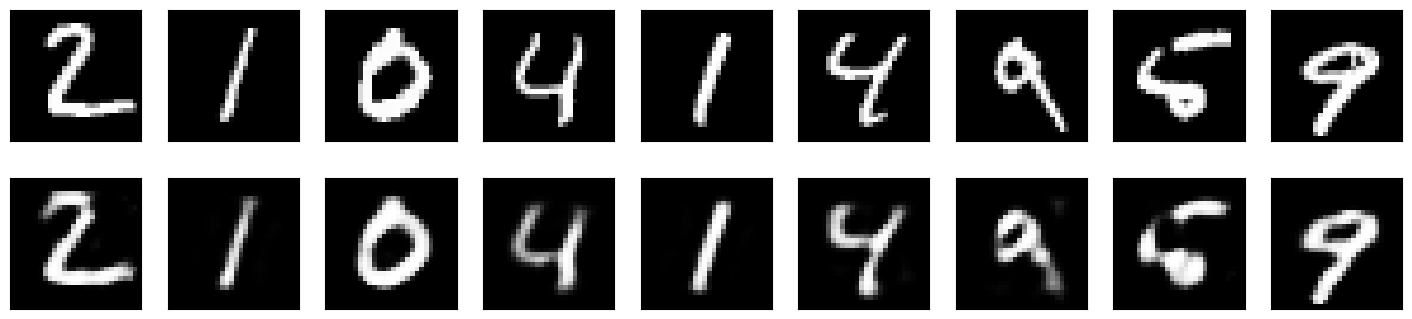

In [9]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))


x_test = x_test.astype('float32') / 255
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [11]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
#TODO configure model to use a binary crossentropy loss, and the Adam optimizer:

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
#TODO complete fit(). Set epoch to 10, batch size to 128, shuffle data, and use x_test as a validation set.
#You can experiment with those values. If training takes a lot of time, try to reduce the number of epochs (but monitor loss value).

autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

decoded_imgs = autoencoder.predict(x_test)

Epoch 1/10
469/469 [==============================] - 34s 71ms/step - loss: 0.2206 - val_loss: 0.1507
Epoch 2/10
469/469 [==============================] - 32s 69ms/step - loss: 0.1396 - val_loss: 0.1306
Epoch 3/10
469/469 [==============================] - 31s 67ms/step - loss: 0.1261 - val_loss: 0.1207
Epoch 4/10
469/469 [==============================] - 32s 67ms/step - loss: 0.1193 - val_loss: 0.1156
Epoch 5/10
469/469 [==============================] - 33s 71ms/step - loss: 0.1148 - val_loss: 0.1116
Epoch 6/10
469/469 [==============================] - 33s 70ms/step - loss: 0.1117 - val_loss: 0.1092
Epoch 7/10
469/469 [==============================] - 35s 76ms/step - loss: 0.1094 - val_loss: 0.1071
Epoch 8/10
469/469 [==============================] - 38s 81ms/step - loss: 0.1077 - val_loss: 0.1060
Epoch 9/10
469/469 [==============================] - 38s 80ms/step - loss: 0.1063 - val_loss: 0.1041
Epoch 10/10
313/313 [==============================] - 3s 8ms/step


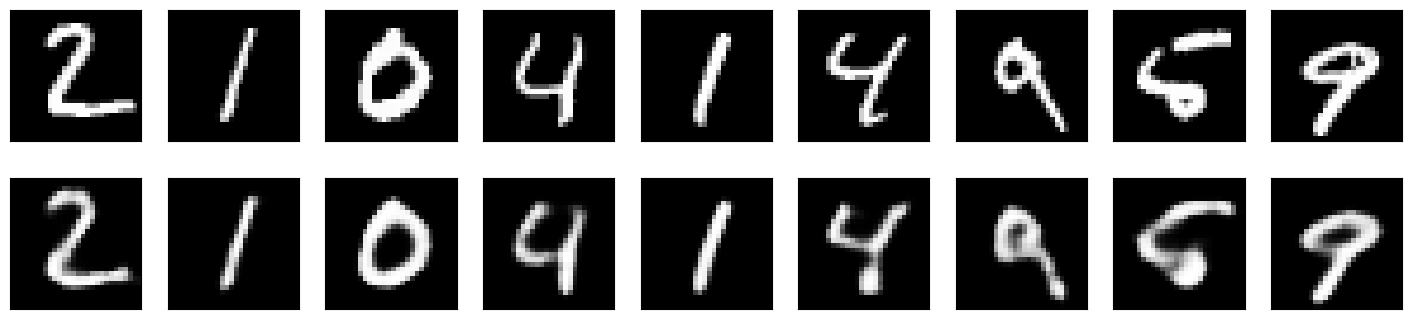

In [12]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()